In [3]:
import ray
from ray.rllib import agents
from ray import tune
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
import gym
from gym import spaces
import or_gym
from or_gym.utils.env_config import *
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
ray.init(ignore_reinit_error=True)

2020-05-07 17:35:17,891	ERROR worker.py:679 -- Calling ray.init() again after it has already been called.


In [153]:
class SchedEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        
        self.num_products = 3
        self.step_limit = 10
        # Set binary transition matrix, from i (row) to j (column)
        self.transition_matrix = np.array([[1, 0, 1],
                                           [0, 1, 1],
                                           [1, 1, 1]])
        self.sales_price = np.ones(self.num_products)
        self.production_rate = [10, 10, 10]
        self.action_setting = 'discrete'
        self.mask = False
        assign_env_config(self, kwargs)
        
        self.action_setting = self.action_setting.lower()
        if self.action_setting == 'discrete':
            # Observations are:
            # Time step (1)
            # Previous action and run rate (2)
            # Current Inventory (num_products)
            # Current Demand (num_products)
            self.obs_dim = self.num_products * 2 + 3
            self.action_space = spaces.Discrete(self.num_products)
        elif self.action_setting == 'continuous':
            # Observations are:
            # Time step (1)
            # Previous action and run rate (2)
            # Current Inventory (num_products)
            # Current Demand (num_products)
            self.obs_dim = self.num_products * 2 + 3
            self.action_space = spaces.Box(
                low=np.zeros(self.num_products), 
                high=self.production_rate)
        else:
            raise NotImplementedError(
                'action_setting = {} has not been defined.'.format(
                    self.action_setting))
        if self.mask:
            self.observation_space = spaces.Dict({
                'action_mask': spaces.Box(0, 1, shape=(self.num_products,)),
                'avail_actions': spaces.Box(0, 1, shape=(self.num_products,)),
                'state': spaces.Box(0, 100, shape=(self.obs_dim,))
            })
        else:
            self.observation_space = spaces.Box(0, 100, shape=(self.obs_dim,))
            
        self.state_indices = {
            'time': 0,
            'prev_actions': [1,2],
            'inventory': 
                {'product_' + str(j): i 
                 for i, j in enumerate(np.arange(self.num_products), 3)},
            'demand': 
                {'product_' + str(j): i 
                 for i, j in enumerate(np.arange(self.num_products), self.num_products + 3)}
        }
        
        self.reset()
        
    def step(self, action):
        done = False
        t = self.current_step
        self.inventory[self.last_action[0]] += self.planned_production
        if self.action_setting == 'continuous':
            product, rate = np.argmax(action), np.max(action)
        else:
            product = action
            rate = self.production_rate[action]
        # To be carried forward to next step
        self.planned_production = self.transition_matrix[self.last_action[0], product] * rate
        
        # Sell products
        sales_qty = [self.demand[t, i] if j else self.inventory[i] 
            for i, j in enumerate(self.inventory>=self.demand[t])]
        self.inventory = np.where(self.inventory - self.demand[t]>=0, 
            self.inventory-self.demand[t], 0)
        self.last_action = [product, rate]
        reward = np.dot(sales_qty, self.sales_price)
        
        self.current_step += 1
        if self.current_step >= self.step_limit:
            done = True
        self.state = self._update_state()
        
        return self.state, reward, done, {}
        
    def reset(self):
        self.demand = self.generate_demand()
        self.inventory = np.zeros(self.num_products)
        # Randomly initialize schedule
        prev_prod = np.random.choice(np.arange(self.num_products))
        if self.action_setting == 'continuous':
            rate = np.random.uniform(low=0, high=self.production_rate[prev_prod])
        else:
            rate = self.production_rate[prev_prod]
        self.planned_production = rate
        self.last_action = [prev_prod, rate]
        self.current_step = 0
                
        return self._update_state()
    
    def _update_state(self):
        t = self.current_step
        state = np.hstack([t, self.last_action, self.inventory, self.demand[t]])
        if self.mask:
            try:
                idx = self.last_action[0]
            except TypeError:
                idx = self.last_action
            action_mask = self.transition_matrix[idx]
            self.state = {'action_mask': action_mask,
                          'avail_actions': np.ones(self.num_products),
                          'state': state}
        else:
            self.state = state.copy()
        return self.state
    
    def generate_demand(self):
        demand = np.zeros((self.step_limit+1, self.num_products))
        for i in range(self.step_limit):
            for j in range(self.num_products):
                if i % self.num_products == j:
                    demand[i, j] += 5
        return demand
    
    def sample_action(self):
        return self.action_space.sample()

In [218]:
np.identity(3)
    return a + a.T - numpy.diag(a.diagonal())

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [237]:
tm = np.random.choice([0, 1], size=(3,3))
tm = tm + tm.T + np.identity(3)
tm = np.where(tm>1, 1, tm)

In [239]:
x = tm.copy()
x

array([[1., 0., 1.],
       [0., 1., 0.],
       [1., 0., 1.]])

In [245]:
idx = np.where(x.sum(axis=1) < 2)[0]
x[idx] += np.random.choice([0, 1], 3)
x

array([[1., 0., 1.],
       [0., 2., 0.],
       [1., 0., 1.]])

In [292]:
def generate_transition_matrix(num_products=6, prob=[0.6, 0.4]):
    tm = np.random.choice([0, 1], p=prob, size=(num_products, num_products))
    tm = tm + tm.T + np.identity(num_products)
    tm = np.where(tm>1, 1, tm)
    # Ensure at least one viable transition for each product
    idx = np.where(tm.sum(axis=1) < 2)[0]
    while len(idx) > 0:
        tm[idx] += np.random.choice([0, 1], p=prob, size=num_products)
        tm = np.where(tm>1, 1, tm)
        idx = np.where(tm.sum(axis=1) < 2)[0]
    return tm

In [294]:
generate_transition_matrix()

array([[1., 1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 0., 1.]])

In [295]:
env.last_action

[2, 10]

In [169]:
config = {'mask': False}
env = SchedEnv(env_config=config)

In [155]:
for i in range(1):
    s = env.reset()
    done = False
    rewards, actions, states = [], [], [s]
    while done == False:
        action = env.sample_action()
        s, r, done, _ = env.step(action)
        rewards.append(r)
        actions.append(action)
        states.append(s)

In [203]:
def test_env(trainer, n_episodes, print_output=True):
    rewards, eps, eps_total = [], [], []
    training_results = []
    training = True
    batch = 0
    env = trainer.env_creator(trainer.config)
    s = env.reset()
    t_start = time.time()
    while training:
        t_batch = time.time()
        results = trainer.train()
        training_results.append(results)
        rewards.append(results['episode_reward_mean'])
        eps.append(results['episodes_this_iter'])
        eps_total.append(results['episodes_total'])
        batch += 1
        t_end = time.time()
        # Check for nan
        out = trainer.compute_action(s)
        if any(np.isnan([out])):
            raise ValueError('NaN found in output')
        if sum(eps) >= n_episodes:
            training = False
            break
        if batch % 10 == 0 and print_output:
            t = t_end - t_batch
            t_tot = t_end - t_start
            print("\rEpisode: {}\tMean Rewards: {:.1f}\tEpisodes/sec: {:.2f}\tTotal Time: {:.1f}s".format(
                eps_total[-1], rewards[-1], eps[-1]/t, t_tot), end="")
            
    print("Total Training Time: {:.1f}s\t".format(t_end - t_start))
    return trainer, training_results

In [204]:
config = agents.a3c.DEFAULT_CONFIG.copy()
config['timesteps_per_iteration'] = 1000
trainer = agents.a3c.A2CTrainer(config=config, env=SchedEnv)

2020-05-07 15:12:45,858	WARNING util.py:45 -- Install gputil for GPU system monitoring.


In [205]:
trainer, results = test_env(trainer, 50000)

Episode: 42910	Mean Rewards: 40.9	Episodes/sec: 201.85	Total Time: 202.9sTotal Training Time: 243.5s	


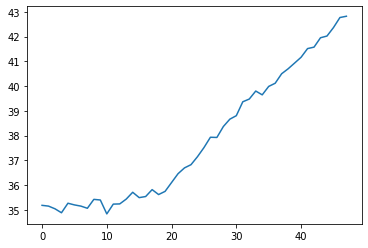

In [206]:
mean_rewards = [i['episode_reward_mean'] for i in results]

plt.figure()
plt.plot(mean_rewards)
plt.show()

In [189]:
env.reset()

array([ 0.,  2., 10.,  0.,  0.,  0.,  5.,  0.,  0.])

In [190]:
env2 = trainer.env_creator(config)
env2.reset()

array([ 0.,  1., 10.,  0.,  0.,  0.,  5.,  0.,  0.])

In [207]:
trainer.compute_action(env2.reset())

2

In [200]:
any(np.isnan([1, np.nan]))

True

In [296]:
s = env.reset()

In [297]:
s

array([ 0.,  2., 10.,  0.,  0.,  0.,  5.,  0.,  0.])

In [298]:
env.observation_space.contains(s)

True

In [4]:
env = or_gym.make('SCSched-v0')

In [5]:
env.reset()

{'action_mask': array([1., 1., 1.]),
 'avail_actions': array([1., 1., 1.]),
 'state': array([ 0.,  0., 10.,  0.,  0.,  0.,  5.,  0.,  0.])}

In [6]:
env.observation_space

Box(9,)

In [9]:
env.inventory[0] += 200
np.where(env.inventory>env.max_inventory,env.max_inventory,env.inventory)

array([100.,   0.,   0.])